## Dimension reduction

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, normalize
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('always')

In [2]:
feature_names = ['Year_Birth', 'Education', 'Marital_Status', 'Income', 'Teenhome', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts']
target = 'Kidhome'

df = pd.read_csv('./marketing_campaign.csv',delimiter='\t')[feature_names + [target]]

df = df.dropna()

le_all = {}
for i in ['Education', 'Marital_Status']:
    le_all[i] = LabelEncoder()
    le_all[i].fit(df[i].unique())
    df[i] = le_all[i].transform(df[i])

df.head()

,Year_Birth,Education,Marital_Status,Income,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,Kidhome
0,1957,2,4,58138.0,0,58,635,88,546,172,0
1,1954,2,4,46344.0,1,38,11,1,6,2,1
2,1965,2,5,71613.0,0,26,426,49,127,111,0
3,1984,2,5,26646.0,0,26,11,4,20,10,1
4,1981,4,3,58293.0,0,94,173,43,118,46,1


In [3]:
X_ = df.drop([target],axis=1)
Y_ = df[target].astype(int)


print('original shapes:', X_.shape, Y_.shape)

original shapes: (2216, 10) (2216,)


In [4]:
scaler = StandardScaler()

X_std = scaler.fit_transform(X_)

pca = PCA()
X_pca = pca.fit_transform(X_std)

In [5]:
exp_var_pca = pca.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

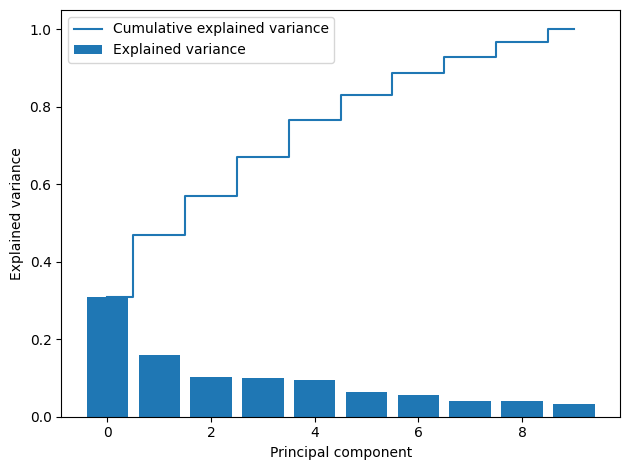

In [6]:
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, align='center', label='Explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance')
plt.xlabel('Principal component')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

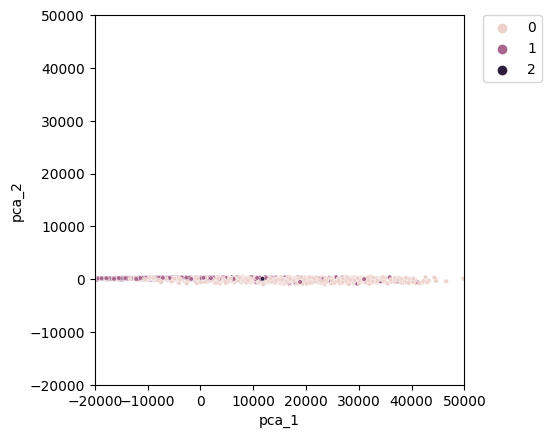

In [7]:
pca = PCA(n_components=2)

pca_result = pca.fit_transform(X_)

pca_result_df = pd.DataFrame({'pca_1': pca_result[:,0], 'pca_2': pca_result[:,1], 'label': Y_})

fig, ax = plt.subplots(1)
sns.scatterplot(x='pca_1', y='pca_2', hue='label', data=pca_result_df, ax=ax,s=10)
lim = (pca_result.mean()-20000, pca_result.mean()+50000)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

## Image recolor

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.utils import shuffle
from time import time
from PIL import Image

In [9]:
img = Image.open("power.jpg")
x = np.asarray(img)

bav = np.array(img, dtype=np.float64) / 255

# Load Image and transform to a 2D numpy array.
w, h, d = original_shape = tuple(bav.shape)
assert d == 3
image_array = np.reshape(bav, (w * h, d))


In [10]:
def recreate_image(codebook, labels, w, h):
    """Recreate the (compressed) image from the code book & labels"""
    return codebook[labels].reshape(w, h, -1)

def recolor(n_colors):
    print("Fitting model on a small sub-sample of the data")
    t0 = time()
    image_array_sample = shuffle(image_array, random_state=0, n_samples=1_000)
    kmeans = KMeans(n_clusters=n_colors, random_state=0).fit(image_array_sample)
    print(f"done in {time() - t0:0.3f}s.")

    # Get labels for all points
    print("Predicting color indices on the full image (k-means)")
    t0 = time()
    labels = kmeans.predict(image_array)
    print(f"done in {time() - t0:0.3f}s.")

    # Display all results, alongside original image
    plt.figure(1)
    plt.clf()
    plt.axis("off")
    plt.title("Original image (96,615 colors)")
    plt.imshow(bav)

    plt.figure(2)
    plt.clf()
    plt.axis("off")
    plt.title(f"Quantized image ({n_colors} colors, K-Means)")
    plt.imshow(recreate_image(kmeans.cluster_centers_, labels, w, h))
    


### 64 colors

Fitting model on a small sub-sample of the data
done in 0.310s.
Predicting color indices on the full image (k-means)
done in 0.047s.


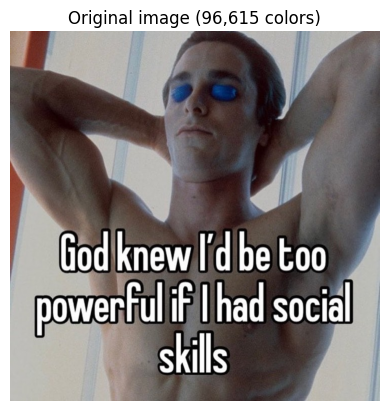

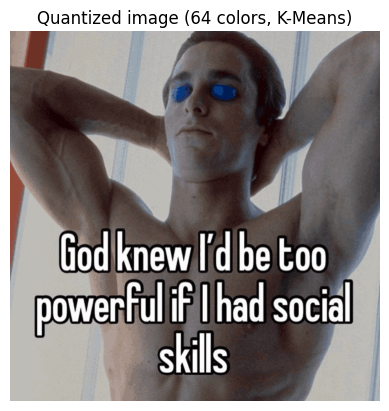

In [11]:
recolor(64)

### 32 colors

Fitting model on a small sub-sample of the data
done in 0.268s.
Predicting color indices on the full image (k-means)
done in 0.048s.


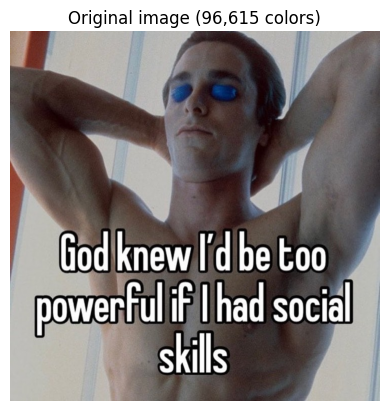

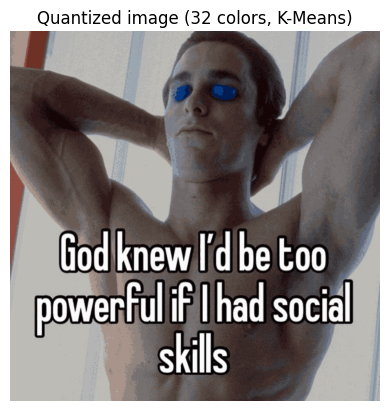

In [12]:
recolor(32)

### 16 colors

Fitting model on a small sub-sample of the data
done in 0.054s.
Predicting color indices on the full image (k-means)
done in 0.026s.


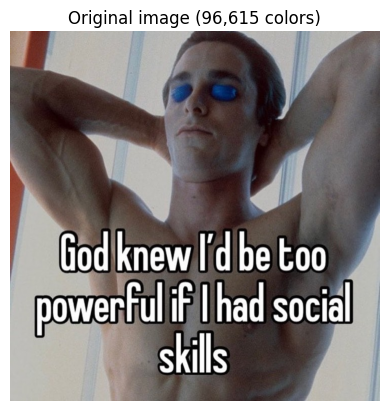

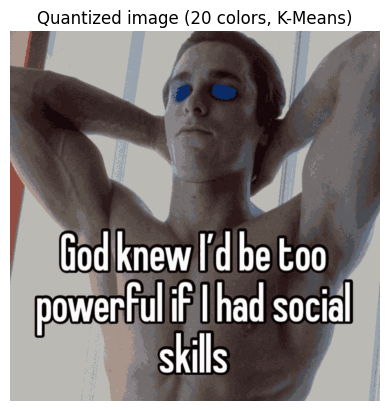

In [13]:
recolor(20)

### 8 colors

Fitting model on a small sub-sample of the data
done in 0.062s.
Predicting color indices on the full image (k-means)
done in 0.012s.


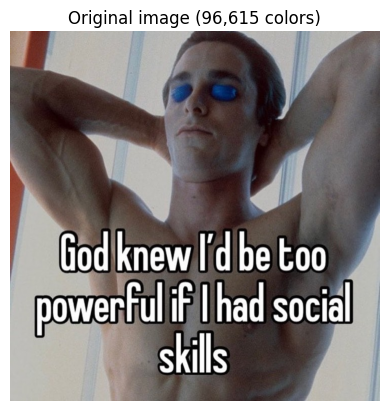

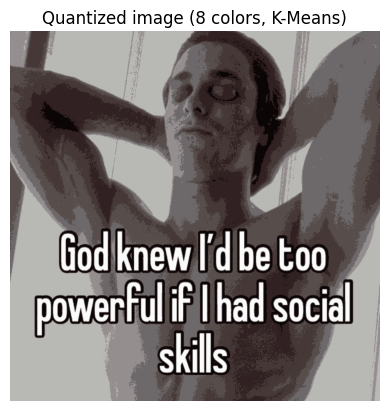

In [14]:
recolor(8)

## Text Processing

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

import string 
import re


In [16]:
stop_words = stopwords.words("english")

def clean_text(text):
    text = text.lower()
    text = re.sub("@\\S+", " ", text)
    text = re.sub("https*\\S+", " ", text)
    text = re.sub("#\\S+", " ", text)
    text = re.sub("\\d", " ", text)
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub('\\n', ' ', text)
    text = re.sub('\\s{2,}',' ', text)
    text = ' '.join([word for word in text.split(' ') if word not in stop_words])
    return text

In [17]:
def load_data(file):
    t_l = file.readlines()
    text = []
    label = []
    for x in t_l:
        x_s = x.split(' ', 1)
        text.append(clean_text(x_s[1]))
        label.append(1 if x_s[0]=="__label__2" else 0)

    return np.array(text), np.array(label)

In [18]:
f = open('datasets/test.ft.txt', 'r')
test_text,test_target = load_data(f)
f.close()

In [19]:
f = open('datasets/train.ft.txt', 'r')
train_text,train_target = load_data( f)
f.close()

In [20]:
df_tr = pd.DataFrame( zip(train_target, train_text), columns=['label','text'])
print(df_tr.head())
df_tst = pd.DataFrame( zip(test_target, test_text), columns=['label','text'])
print(df_tst.head())

   label                                               text
0      1  stuning even non gamer sound track beautiful p...
1      1  best soundtrack ever anything reading lot revi...
2      1  amazing soundtrack favorite music time hands i...
3      1  excellent soundtrack truly like soundtrack enj...
4      1  remember pull jaw floor hearing played game kn...
   label                                               text
0      1  great cd lovely pat one great voices generatio...
1      1  one best game music soundtracks game really pl...
2      0  batteries died within year bought charger jul ...
3      1  works fine maha energy better check maha energ...
4      1  great non audiophile reviewed quite bit combo ...


In [ ]:
from wordcloud import WordCloud,STOPWORDS

plt.figure(figsize = (20,20)) # Text that is not Fake
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(df_tr[df_tr.label == 1].text))
plt.imshow(wc , interpolation = 'bilinear')